In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
from helper_classes.PreProcessData import clean_text, read_corpus
from helper_classes.DatabaseHelper import fetch_travel_packages_data, get_evaluation_score
from helper_classes.Metrics import recall, precision, mrr
from helper_classes.Evaluation import Evaluator

In [3]:
metrics = {'precision': precision, 'recall': recall, 'mrr': mrr}

Get all the travel package data.
Columns to get: id, nazev, popisek, do

In [4]:
travel_package = fetch_travel_packages_data()

Column 'do' will not be used for Doc2Vec training. It is used for getting the last information regarding the travel package. Then it is dropped from the dataframe.

In [5]:
columns = ['id', 'nazev', 'popisek', 'do']
travel_package_df = pd.DataFrame(data=travel_package, columns=columns)
travel_package_df = travel_package_df.sort_values('do').drop_duplicates('id', keep='last').sort_index()
travel_package_df = travel_package_df.drop(columns=['do'])
travel_package_df.head()

,id,nazev,popisek
1,1,- Romantikou Anglie a Skotska -,"Velká Británie je složena ze 4 zemí - Anglie, ..."
5,3,- PERLY TOSKÁNSKA -,"Vedle proslulých, každému známých a turisty ne..."
10,6,- Královská Provence -,"Kraj plný rytířských hradů, romantických zámků..."
16,8,- Paříž a zámky francouzských králů -,"Říká se, že kdo neviděl Paříž, ten nepoznal Ev..."
48,10,"- Termignon, Residence Les Balcons de la Vano...",Termignon patří mezi menší francouzská zimní s...


In [6]:
result_df = travel_package_df.apply(lambda x: ','.join(x.astype(str)), axis=1)

In [7]:
result_df = clean_text(result_df)
result_df.head()

1     1, romantikou anglie a skotska ,velká británie...
5     3, perly toskánska ,vedle proslulých, každému ...
10    6, královská provence ,kraj plný rytířských hr...
16    8, paříž a zámky francouzských králů ,říká se,...
48    10, termignon, residence les balcons de la van...
Name: clean, dtype: object

In [ ]:
train_corpus = list(read_corpus(result_df))
print(train_corpus[:2])

In [8]:
Load Doc2Vec Model and Item Vectors

[TaggedDocument(words=['romantikou', 'anglie', 'skotska', 'velká', 'británie', 'je', 'složena', 'ze', 'zemí', 'anglie', 'skotska', 'walesu', 'severního', 'irska', 'každá', 'nich', 'nabízí', 'něco', 'jiného', 'pokud', 'jde', 'tradice', 'historii', 'krajinu', 'lidi', 'romantické', 'hory', 'poklidná', 'jezera', 'zvlněné', 'zelené', 'kopce', 'zalesněná', 'údolí', 'divoká', 'pobřeží', 'to', 'vše', 'uvidíte', 'během', 'desetidenního', 'zájezdu', 'po', 'místech', 'anglie', 'skotska'], tags=['1']), TaggedDocument(words=['perly', 'toskánska', 'vedle', 'proslulých', 'každému', 'známých', 'turisty', 'míst', 'itálii', 'jako', 'jsou', 'benátky', 'řím', 'či', 'florencie', 'je', 'na', 'území', 'itálie', 'nespočetné', 'množství', 'dalších', 'zajímavostí', 'památek', 'právě', 'takováto', 'místa', 'která', 'se', 'ne', 'vždy', 'dostávají', 'do', 'programu', 'tradičních', 'tras', 'zájezdů', 'vám', 'chceme', 'nabídnout', 'při', 'našich', 'toulkách', 'toskánskem'], tags=['3'])]


Load Doc2Vec Model and Item Vectors

In [9]:
model_path = f'D:/Thesis/recsys_thesis/models/doc2vec.model'
file = open(model_path, 'rb')
model = pickle.load(file)

In [10]:
items_path = f'D:/Thesis/recsys_thesis/models/items_pickle.items'
items_file = open(items_path, 'rb')
items = pickle.load(items_file)

Evaluation Metrics:
 1. **metrics**
		 - Precision: What proportion of positive identifications was actually correct?
		 - Recall: What proportion of actual positives was identified correctly?
		 - Mrr: Measure to evaluate systems that return a ranked list of answers to queries
 3. **model_name:** Name of the recommendation model. 
 4. **given_k:** Number of items user will has in her/his profile
 5. **look_ahead:** Ground Truth top_n => Number of items to consider for
 6. **prediction step:** How many steps will be taken after the evaluation.


In [11]:
metrics = {'precision': precision, 'recall': recall, 'mrr': mrr}
model_name = 'd2v'
given_k = 1
look_ahead = 'all'
top_n = 10
step = 1

In [ ]:
for user_id, user_sequence in train_data:
    item2vec_evaluator = Evaluator(recommender_model=model,
                                   recommender_name=model_name,
                                   metrics=metrics,
                                   items=items,
                                   test_sequence=user_sequence,
                                   given_k=given_k,
                                   look_ahead=look_ahead,
                                   top_n=top_n,
                                   step=step)
    
    evaluation_result = item2vec_evaluator.sequential_evaluation()
    
    
    metric_results = list(zip(metrics.keys(), evaluation_result))
    
    user_average_precision = round(metric_results[0][1], 2)
    user_average_recall = round(metric_results[1][1], 2)
    user_average_mrr = round(metric_results[2][1], 2)
    
    print(f'User {user_id} has been evaluated.. >> {user_average_precision} >> {user_average_recall} >> {user_average_mrr}')

After evaluating the model, retrieve the results from the database.

In [12]:
user_scores = get_evaluation_score('d2v')


In [13]:
df_user_scores = pd.DataFrame(user_scores, columns=['user_id', 'avg_precision', 'avg_recall', 'avg_mrr'])
df_user_scores['user_id'] = df_user_scores['user_id'].astype(int)
df_user_scores['avg_precision'] = df_user_scores['avg_precision'].astype(float)
df_user_scores['avg_recall'] = df_user_scores['avg_recall'].astype(float)
df_user_scores['avg_mrr'] = df_user_scores['avg_mrr'].astype(float)
df_user_scores.head()

,user_id,avg_precision,avg_recall,avg_mrr
0,3379588,0.5,0.83,0.5
1,3349963,0.4,0.50,1.0
2,3367370,0.4,0.57,1.0
3,3395510,0.4,1.00,0.5
4,3347716,0.3,0.75,1.0


In [14]:
distinct_user_count = len(df_user_scores)
print('Nummber of the unique user count: ', distinct_user_count)

Nummber of the unique user count:  4105


Get the number of 'hits'

In [15]:
hit_counter = np.count_nonzero(df_user_scores['avg_precision'])
not_hit_counter = distinct_user_count - hit_counter
print(hit_counter)

627


In [16]:
import seaborn as sns

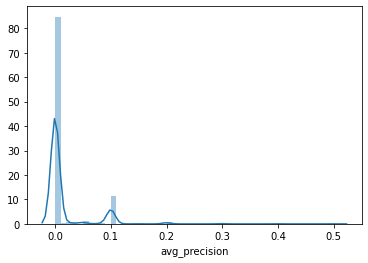

In [17]:
sns.distplot(df_user_scores['avg_precision'])

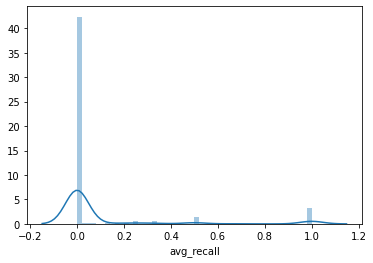

In [18]:
sns.distplot(df_user_scores['avg_recall'])

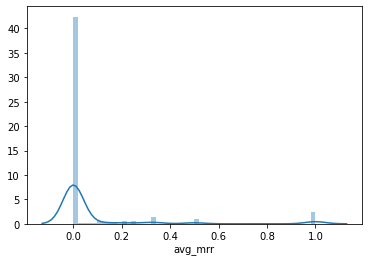

In [19]:
sns.distplot(df_user_scores['avg_mrr'])

In [20]:
def test(row):
    if (row.avg_precision > 0) and (row.avg_recall > 0) and (row.avg_mrr > 0):
        return 1
    else:
        return 0

In [21]:
df_user_scores['hit'] = df_user_scores.apply(test, axis=1)

In [22]:
df_user_scores.head()

,user_id,avg_precision,avg_recall,avg_mrr,hit
0,3379588,0.5,0.83,0.5,1
1,3349963,0.4,0.50,1.0,1
2,3367370,0.4,0.57,1.0,1
3,3395510,0.4,1.00,0.5,1
4,3347716,0.3,0.75,1.0,1


In [23]:
number_of_hits = len(df_user_scores[df_user_scores['hit'] == 1])
print('Number of hits: ', number_of_hits)

Number of hits:  627


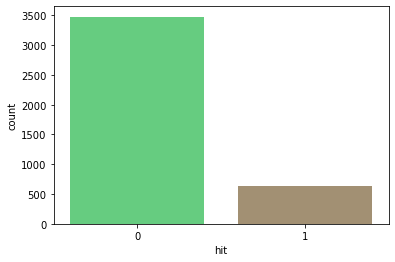

In [24]:
sns.countplot(x='hit',data=df_user_scores, palette='terrain')

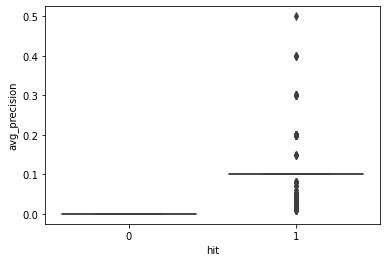

In [25]:
sns.boxplot(x='hit', y='avg_precision', data=df_user_scores)

In [26]:
df_user_scores.drop(columns=['user_id'], inplace=True)
df_user_scores.drop(columns=['hit'], inplace=True)

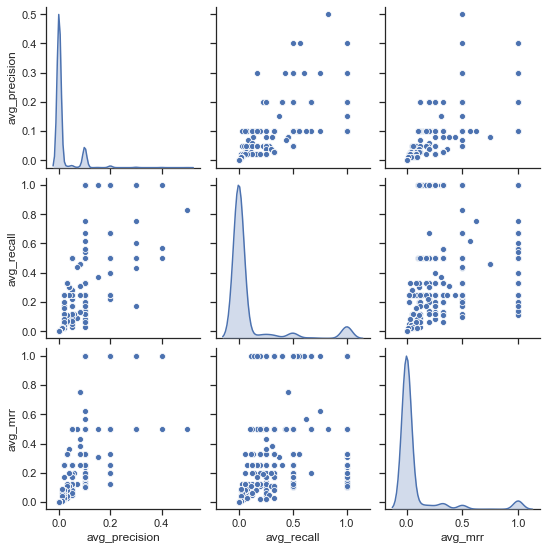

In [27]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
sns.pairplot(df_user_scores, diag_kind="kde")